In [1]:
import sys
sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils.data import wikitext103_loader
from omegaconf import OmegaConf

import torch
import numpy as np

In [4]:
cfg = OmegaConf.load('../config/conf.yaml')

In [5]:
cfg

{'deploy': False, 'tag': 'minLM_run1', 'seed': 0, 'device': 'cuda:0', 'epochs': 50, 'data': {'bs': 32, 'tokenizer': 'openai-community/gpt2', 'subsample': 0.01}, 'net': {'compile': True, 'vocab_size': 512, 'context_size': 256, 'n_layer': 12, 'n_head': 12, 'n_embd': 120, 'dropout': 0.0, 'bias': False}, 'optimizer': {'learning_rate': 0.0003, 'weight_decay': 0.1, 'beta1': 0.9, 'beta2': 0.95, 'grad_clip': 1.0, 'decay_lr': True, 'min_lr': 3e-05}, 'log': {'eval_interval': 200, 'log_interval': 10}, 'defaults': ['_self_', {'override hydra/job_logging': 'disabled'}, {'override hydra/hydra_logging': 'disabled'}], 'hydra': {'output_subdir': None, 'job': {'chdir': False}, 'run': {'dir': '.'}, 'sweep': {'dir': '.', 'subdir': '.'}}}

In [6]:
cfg.data.subsample = 0.01
cfg.net.context_size = 1024

In [7]:
trainloader = wikitext103_loader(cfg, train=True)

/Users/rahul/micromamba/envs/incontext/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Filter:   0%|          | 0/8531 [00:00<?, ? examples/s]

# Analyze lengths

In [8]:
lns = []
for dat in trainloader:
    dat = dat['input_ids']
    lns.append(torch.argmax((dat == 50256).float(), dim=1).numpy())
lns = np.concatenate(lns)

lns[lns == 0] = cfg.net.context_size

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

/Users/rahul/micromamba/envs/incontext/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/rahul/micromamba/envs/incontext/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


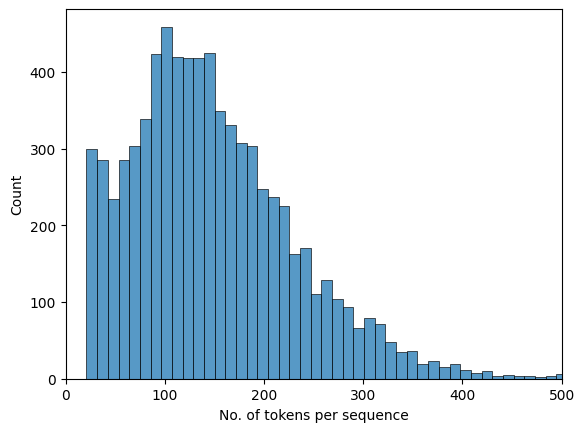

In [10]:
sns.histplot(lns)
plt.xlim([0, 500])
plt.xlabel("No. of tokens per sequence")
plt.savefig("./figures/01_numtokens.pdf", bbox_inches="tight")
plt.show()

In [12]:
print(np.min(lns))
print(np.max(lns))
print(np.median(lns))
print(np.mean(lns))

21
796
137.0
149.05043685464653


In [13]:
ind = np.where(lns == 3)[0]

In [14]:
len(ind)

0

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(cfg.data.tokenizer)
tokenizer.pad_token = tokenizer.eos_token

/Users/rahul/micromamba/envs/incontext/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
small = []
for dat in trainloader:
    dat = dat['input_ids']
    cln = torch.argmax((dat == 50256).float(), dim=1).numpy()

    ind = np.where(cln <= 10)[0]
    small.append(dat[ind].numpy())

In [17]:
small

[array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=int64),
 array([], shape=(0, 1024), dtype=

In [18]:
small = np.concatenate(small)

In [19]:
for i in range(len(small)):
    ind =  np.where(small[i] == 50256)[0][0]
    txt = small[i][:ind]
    print(ind, tokenizer.decode(txt).strip())